In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import comet_ml
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from train import set_up_omegaconf, OmegaConf
from src.trainer.trainer import EbirdTask, EbirdDataModule
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from typing import Any, Dict, Tuple, Type, cast
from src.dataset.utils import set_data_paths
import numpy as np
from PIL import Image

In [8]:
conf = OmegaConf.load("../configs/defaults.yaml")
conf = OmegaConf.merge(
        conf, OmegaConf.load("../configs/debugging.yaml")
    )
conf = set_data_paths(conf)
task = EbirdTask(conf)
datamodule = EbirdDataModule(conf)

datamodule.setup()
it = datamodule.all_train_dataset.__getitem__(0)

{'save_path': '/network/projects/_groups/ecosystem-embeddings/exps/hawk_init', 'load_ckpt': '', 'log_comet': True, 'overfit_debug': False, 'overfit_batches': 5, 'loc': {'use': True, 'concat': False, 'elev': False, 'num_checklists': False}, 'comet': {'project_name': 'hawk_init', 'tags': ['hawk', 'overfit', 'l1', 'image', 'no_trasforms', 'env']}, 'experiment': {'task': 'ebird_classifier', 'name': 'ebird_classifier', 'seed': 42, 'module': {'model': 'resnet18', 'pretrained': False, 'init_bias': 'no', 'means_path': '/network/scratch/t/tengmeli/scratch/ecosystem-embedding/training/means_all_species.npy', 'lr': 0.0001}}, 'optimizer': 'SGD', 'scheduler': {'name': 'ReduceLROnPlateau', 'reduce_lr_plateau': {'factor': 0.1, 'lr_schedule_patience': 3}, 'step_lr': {'step_size': 10, 'gamma': 0.5}, 'warmup': {'warmup_epochs': 10, 'max_epochs': 100}, 'cyclical': {'warmup_epochs': 10}}, 'variables': {'ped_means': [2230.56361696, 1374.68551614, 20.45478794, 19.04921312, 31.1196319, 61.24246466, 36.687116

In [9]:
#check that we have the right number of ped data:
# typically we have cropped the satellite image to 64*64 image --> 640*640 m 
#given the resolution of pedological data is 250 m, we expect to have something like a 3*3 grid that corresponds to the 640*640 m
#bioclimatic data is 1km resolution, so we should just have one value (max 4) -check for one variable
len(np.unique(it["ped"].squeeze(0).cpu().numpy()[0,:,:])), len(np.unique(it["bioclim"].squeeze(0).cpu().numpy()[0,:,:]))


(9, 1)

In [11]:
it.keys()

dict_keys(['ped', 'bioclim', 'sat', 'target', 'num_complete_checklists', 'hotspot_id', 'lon', 'lat', 'area_geom', 'date', 'loc'])

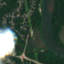

In [32]:
#check that we have indeed cropped in the middle -- original image
arr = np.load('/ecosystem-embedding/satellite_data/%s_rgb.npy' % it["hotspot_id"])
c,h,w = arr.shape
Image.fromarray(np.transpose(arr[:, h//2-32:(h//2)+32, (w//2)-32:w//2+32], (1,2,0)))

In [26]:
#cropped image in our dataloader

#this is what we normalized by 
means= [87.0467011965099, 91.21045367500467, 67.50251448722302]
std = [67.55043009747773, 51.443316800384295, 49.65159018638426]
std_ = np.transpose(np.tile(np.array(std), (256,256,1)), (2,0,1))
#only keep rgb bands
aa = (it["sat"].squeeze(0)[:3].cpu().numpy() * std_) + np.transpose(np.tile(np.array(means), (256,256,1)), (2,0,1))

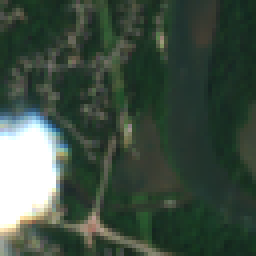

In [30]:
Image.fromarray(np.transpose(aa.astype(np.uint8), (1,2,0)))

It's the same region, all good !

In [41]:
#check pedological data

In [45]:
#first pedological variable (index 3 because we have rgb, then ped data, then bioclim concatenated)
it["sat"][0,3,:,:]

tensor([[-0.1212, -0.1212, -0.1212,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1212, -0.1212, -0.1212,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1212, -0.1212, -0.1212,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0198, -0.0198, -0.0198,  ...,  0.0592,  0.0592,  0.0592],
        [-0.0198, -0.0198, -0.0198,  ...,  0.0592,  0.0592,  0.0592],
        [-0.0198, -0.0198, -0.0198,  ...,  0.0592,  0.0592,  0.0592]])

In [36]:

ped = np.load('/ecosystem-embedding/hotspot_ped_var/%s.npy' % it["hotspot_id"])

In [40]:
(ped[0][4:7, 4:7] - 2230.56361696) / 2355.3843

array([[-0.12123869, -0.11741766,  0.        ],
       [ 0.05707616, -0.00108845,  0.05198145],
       [-0.01976905, -0.02146729,  0.05919895]], dtype=float32)

# debug dataloader when using reflectance values r,g,b,nir

In [3]:
conf = OmegaConf.load("../configs/defaults.yaml")
conf = OmegaConf.merge(
        conf, OmegaConf.load("../configs/debugging_refl.yaml")
    )
conf = set_data_paths(conf)
task = EbirdTask(conf)
datamodule = EbirdDataModule(conf)

datamodule.setup()
it = datamodule.all_train_dataset.__getitem__(0)

{'save_path': '/network/projects/_groups/ecosystem-embeddings/exps/debug', 'load_ckpt': '', 'log_comet': True, 'overfit_debug': False, 'overfit_batches': 5, 'loc': {'use': False, 'concat': False, 'elev': False, 'num_checklists': False}, 'comet': {'project_name': 'debug', 'tags': ['not_songnirds', 'overfit', 'l1', 'image', 'no_trasforms', 'env']}, 'experiment': {'task': 'ebird_classifier', 'name': 'ebird_classifier', 'seed': 42, 'module': {'model': 'resnet18', 'pretrained': False, 'init_bias': 'no', 'means_path': '/network/scratch/t/tengmeli/scratch/ecosystem-embedding/training/means_all_species.npy', 'lr': 0.0001}}, 'optimizer': 'SGD', 'scheduler': {'name': 'ReduceLROnPlateau', 'reduce_lr_plateau': {'factor': 0.1, 'lr_schedule_patience': 3}, 'step_lr': {'step_size': 10, 'gamma': 0.5}, 'warmup': {'warmup_epochs': 10, 'max_epochs': 100}, 'cyclical': {'warmup_epochs': 10}}, 'variables': {'ped_means': [2230.56361696, 1374.68551614, 20.45478794, 19.04921312, 31.1196319, 61.24246466, 36.6871

In [7]:
means, std = [1250.1775, 1088.0417, 818.9687, 2414.3396], [869.4265, 1404.824, 1284.3544, 2272.3147]

In [8]:
rgb = it["sat"][0, :3, :,:]

In [10]:
means_ = np.transpose(np.tile(np.array(means[:3]), (256,256,1)), (2,0,1))
std_ = np.transpose(np.tile(np.array(std[:3]), (256,256,1)), (2,0,1))

In [12]:
rgb = rgb.cpu().numpy()

In [17]:
max_ = np.max(rgb, axis = (1,2))
min_ = np.min(rgb, axis = (1,2))

In [20]:
max_ = np.transpose(np.tile(np.array(max_), (256,256,1)), (2,0,1))
min_ = np.transpose(np.tile(np.array(min_), (256,256,1)), (2,0,1))

In [22]:
norm = (rgb - min_) / (max_ - min_)

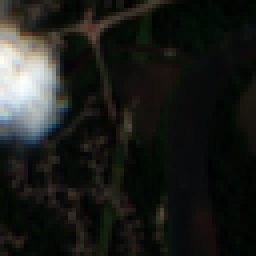

In [24]:
Image.fromarray(np.transpose((norm*255).astype(np.uint8), (1,2,0)))